In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.insert(0, '/Users/kedzie/repos/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import bokeh
import scipy
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import read_data, read_press, getnearpos, folder_files, headspace
from utility_functions.utils import getnearpos
from utility_functions.other_utils.more_garbage import garb

In [3]:
h2base= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/190308_2channels_h2baseline_nocells_Ar/190308_2channels_h2baseline_nocells_ch1_2019-03-08_11.23_22_ch1.txt')
zncor1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190308_raj_zncorrosionstudy_dems/2019-03-08_DEMS_rawdata/20190308-cell3/Cell3_2019-03-08_14.44_13_ch1.txt')


NameError: name 'read_dems' is not defined

In [ ]:
na_ion = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190309_naIon_xiaoli_c20_dems/cell1/')
ion_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190309_naIon_xiaoli_c20_dems/cell1/190309_naIon_xiaoli_c20_dems_cell1_2019-03-09_15.36_53_ch1.txt')
#mz2= -1.89296*10**-10*np.log(ion_dems['time/min']) + 2.64566*10**-9

mz2= -4.85933*10**-19*ion_dems['time/min']**3 + 2.00656*10**-15*ion_dems['time/min']**2 - 2.42074*10**-12*ion_dems['time/min'] + 1.96360*10**-9
ion_dems['2']= ion_dems['2']-mz2
mz32= -4.88768*10**-12*np.log(ion_dems['time/min']) + 5.25977*10**-11
ion_dems['32']= ion_dems['32']-mz32
mz44= -1.18646*10**-14* ion_dems['time/min'] + 4.81050*10**-11
ion_dems['44']= ion_dems['44']-mz44

index1 = getnearpos(ion_dems['time/min'], na_ion[0]['time/s'].iloc[-1]/60)
timediff= np.mean(np.gradient(ion_dems['time/min']))
    

umoles=convert_ion_current(ion_dems)
start_ch= ion_dems['time/min'].iloc[0]
end_ch= na_ion[1]['time/s']


# oxy = baselinecorr( umoles,32,na_ion[0]['time/s'].iloc[-1],2000)
# hydro = baselinecorr(oxy,2,na_ion[0]['time/s'].iloc[-1],1200)
# co2 = baselinecorr(hydro,44,na_ion[0]['time/s'].iloc[-1],1500)
# c2h4 = baselinecorr(co2,26,na_ion[0]['time/s'].iloc[-1],1500)
# co = baselinecorr(c2h4,28,na_ion[0]['time/s'].iloc[-1],1500)


endcap= na_ion[1]['Capacity/mA.h'].iloc[-1]/.01184
fig, ax= plt.subplots( figsize= (9,10)) 
ax2=ax.twinx()
startcap=umoles['time/min'][index1]/60*0.1184/.01184

ax.plot((na_ion[1]['Capacity/mA.h']/.01184), na_ion[1]['Ewe/V'], 'k')
ax.plot(endcap+(na_ion[3]['Capacity/mA.h']/.01184), na_ion[3]['Ewe/V'], color='k')

ax2.plot(umoles['time/min'][index1:-15]/60*0.1184/.01184-startcap, umoles['2'][index1:-15]/timediff, 'o', markersize=5, mfc='none', label='H$_2$')
ax2.plot(umoles['time/min'][index1:-15]/60*0.1184/.01184-startcap, umoles['32'][index1:-15]/timediff, 'o', markersize=5, mfc='none', label='O$_2$')
ax2.plot(umoles['time/min'][index1:-15]/60*0.1184/.01184-startcap, umoles['44'][index1:-15]/timediff, 'o', markersize=5, mfc='none', label='CO$_2$')

# ax2.fill_between(umoles['time/min'][index1:-15]/60*0.1184/.01184- startcap, 0, umoles['2'][index1:-15]/timediff, color=(0.2, 0.4, 0.6, 0.3), label='')
# ax2.fill(umoles['time/min'][index1:-15]/60*0.1184/.01184 - startcap, umoles['44'][index1:-15]/timediff, color=(0.2, 0.6, 0.2, 0.3), label='')
# ax2.fill(umoles['time/min'][index1:-15]/60*0.1184/.01184 - startcap, umoles['32'][index1:-15]/timediff, color=(0.956, 0.623, 0.184, 0.4), label='')


ax2.legend()
umoles['32'].iloc[0]=0

uo=(np.cumsum(umoles['32']).iloc[-15])
uco2= np.cumsum(umoles['44']).iloc[-15]
ax.set_xlabel("Capacity (mAh/g)")
ax.set_ylabel("Potential (V vs. Na$^+$/Na$^0$)")
ax2.set_ylabel('Rate of Gas Evolution ($\mu$moles / min)')

Final= pd.DataFrame(data=[umoles['time/min'], umoles['2'], umoles['32'], umoles['44']])

print('cumulative o2: '+  str(uo))
print('cumulative co2: '+  str(uco2))
#Final.to_csv('/Users/kedzie/Desktop/xiaolicell1.csv')
#plt.savefig('/Users/kedzie/Desktop/dems_sodiumion_cOver20_dems_cell1.png', transparent = True, dpi=600, bbox_inches='tight')



In [131]:

#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

In [132]:
def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    #new as of 
    m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955]
    m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    
    #inf_ar = 278.6590323 * demsdata['36']
    inf_ar = 288.7462016 * demsdata['36']   #as of 2/2019
    
    names= ['2','26','28','32','34','36','44','45']
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
       
    
#     for i in range(len(names)):
#         demsdata[names[i]] = demsdata[names[i]] * vol / R / ( demsdata['temperature/C'] + 273 )

    return (demsdata) 



In [133]:
def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    index = getnearpos(data['time/min'], end1/60)
    index2 = getnearpos(data['time/min'], start2)
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--')


    #convert mass data into dataframe variables
    d = {'time/min' : data['time/min'][:index], str(mz) : data[str(mz)][:index], }
    d2 =  {'time/min' : data['time/min'][index2:], str(mz): data[str(mz)][index2:] }

    df = pd.DataFrame(d)
    df2 = pd.DataFrame(d2)
    newdf = pd.DataFrame()
    newdf = pd.concat([df,df2])
    row,col= data.shape
    correct = [0]* row
    
    if mz == 2:
        correct= -9.8617*10**-9*data['time/min']**2 + 1.2971*10**-5*data['time/min'] + 1.7803*10**-2
    elif mz==32:
        correct = -4.0880*10**-6*data['time/min'] + 1.0521*10**-2
    elif mz==44:
        correct = -2.3401*10**-6*data['time/min'] + 1.5931*10**-2
    plt.plot(data['time/min'], correct, '.')
    data[str(mz)] = data[str(mz)]-correct
    
    def exp_pos(dat, a, b, c):
        return (a * np.exp(b * dat) + c)
    def exp_neg(dat,a,b,c):
        return (a * np.exp(-b * dat) + c)
    def one_over(dat,a,b):
        return (a/(dat)+b)
    def ln(dat,a,b, c):
        return (a*np.log(b*dat)+c)
    def ln_neg(dat,a,b):
        return (-a*np.log(dat)+b)
    def tenpower(dat,a,b,c):
        return (a*10**(b*dat)+c)
    def tenpower_min(dat,a,b,c):
        return (a*10**(-b*dat)+c)
    
   #fix this!!! 
#     vals, covar =curve_fit(exp_pos , numpy.asarray(newdf['time/min']), numpy.asarray(newdf['mz'])*10**9)
#     val2, covar2 =curve_fit(one_over , numpy.asarray(newdf['time/min']), numpy.asarray(newdf['mz'])*10**9)     
#    val3, covar3 =curve_fit(ln , np.asarray(newdf['time/min']), numpy.asarray((newdf['mz']))*10**9)
    val4, covar4 = curve_fit(ln , np.asarray(newdf['time/min'])[1:], np.asarray((newdf[str(mz)]))[1:]*10**9)
    #plt.figure()
    ynew = ln(data['time/min'], *val4 )
    
    #data[str(mz)] = data[str(mz)] - ynew

#     res1=0
#     y=one_over(newdf['time/min'],val2[0],val2[1])
#     for l in range(0,len(newdf['time/min'])):
#         res1=res1+(newdf['mz'].iloc[l]-y.iloc[l])**2
          
    def residuals(data: Iterable, fit: Iterable):
        """
        Return the residuals b/w data array and fit
        """
        return np.sum((np.array(data)-np.array(fit))**2)
    #resi=[residuals(newdf['mz'], one_over(newdf['time/min'],val2[0],val2[1]))]
    #resi.append()
    #print (resi)
    #plt.figure(facecolor='white')
    
    #plt.plot(data['time/min'],(exp_fit(data['time/min'],vals[0],vals[1],vals[2])), label='exponent')
    #plt.plot(data['time/min'],(one_over(data['time/min'],val2[0],val2[1])), label='1/x')
    #plt.plot(data['time/min'],(log(data['time/min'],val3[0], val3[1], val3[2])), label='log')
    #plt.plot(data['time/min'],(log_min(data['time/min'],val4[0], val4[1], val4[2])), label='-log')
    resid_poly=[]
    for i in range(1,5):
        coeff=np.polynomial.polynomial.polyfit(newdf['time/min'],newdf[str(mz)]*10**9,i)
        x=data['time/min']
        y=[0]
        for j in range(0,i+1):
            y=y+coeff[j]*x**j
        
        res=0
        for k in range(0,len(newdf['time/min'])):
            res= res + (newdf[str(mz)].iloc[k]*10**9-y.iloc[k])**2
        resid_poly.append(res)
        
    #plt.plot(x, y, label='polynomial order {}'.format(i))
    
    #plt.legend(fontsize=8, loc=1)
    
    #plt.plot(newdf['time/min'],newdf['mz']*10**9, 'o', mfc= 'none')
    #plt.xlabel('Time(min)')
    #plt.ylabel('Ion Current (nA)')
    
    m = (df[str(mz)].iloc[-1]-df2[str(mz)].iloc[0])/(df['time/min'].iloc[-1]-df2['time/min'].iloc[0])
    
    def lin(fullfile,time,maz,cpstart,cpend):
        m= (maz.iloc[cpend]-maz.iloc[cpstart]) / (time.iloc[cpend]-time.iloc[cpstart])
        line=(m*(time-time.iloc[cpstart]) + maz.iloc[cpstart])
        fullfile[str(mz)]= fullfile[str(mz)] - line
        for i in range(0,index):
            fullfile[str(mz)].iloc[i]=fullfile[str(mz)].iloc[i]-fullfile[str(mz)].iloc[i]
        #for i in range(index2,len(fullfile)):   
        #    fullfile[str(mz)].iloc[i]=fullfile[str(mz)].iloc[i]-fullfile[str(mz)].iloc[i]
        #for i in range (index,index2):
        #    fullfile[str(mz)].iloc[i]= fullfile[str(mz)].iloc[i] - line.iloc[i]
        
        return fullfile
    
    #co1= np.polyfit(np.log(newdf['time/min']), newdf[str(mz)], deg=1)
    #baselinecorr= co1[0]*np.log(data['time/min'])+col[1]
    #data[str(mz)] = data[str(mz)]-baselinecorr
    
    #recomment this for linear baseline
    #datacorr=lin( data, data['time/min'], data[str(mz)], index-1, index2 )

    plt.plot(data['time/min'], data[str(mz)], '-.')
    plt.legend()                            
    #ret=datacorr
    
    return (data)


0.9079581623276074
25.837851 microamps


/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in log
/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log


31.52665196155033 0.4083725185865718 -0.019655367828186332
umoles O2: 31.52665196155033
e per mol: 1.0745600352901554
pred
0.8266737560431161
29.798797880280055 0.3157558744721094 0.051590658394763
umoles O2: 29.798797880280055
e per mol: 1.0350899827741862


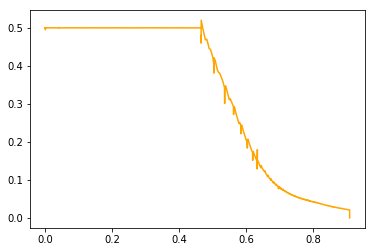

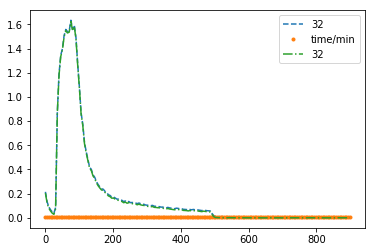

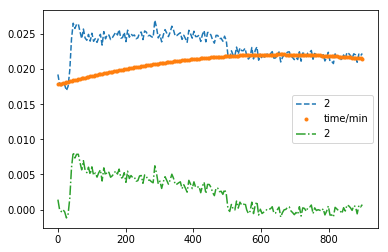

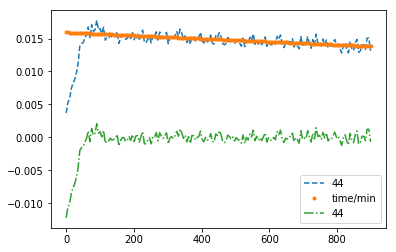

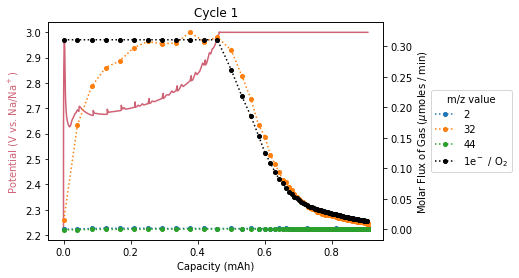

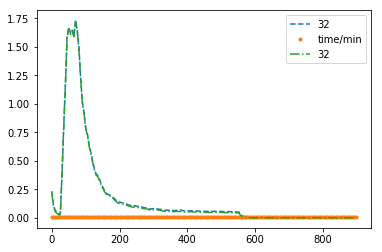

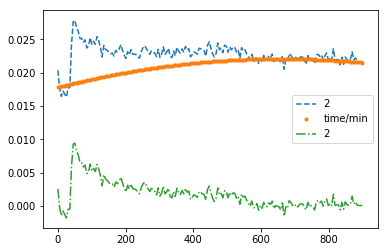

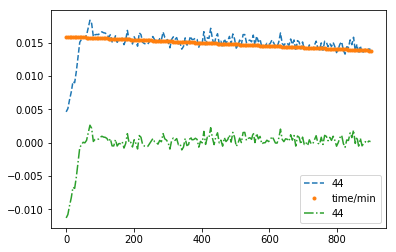

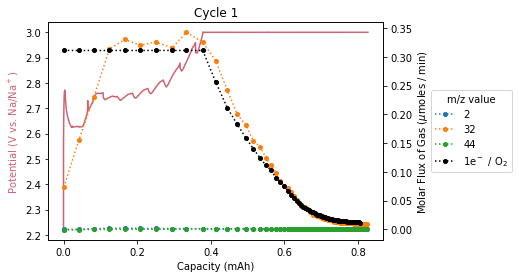

In [185]:
#c13= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/190213_Na_CA_C13_18O2cycling_cell1_chrg_cycle1_2019-02-13_12.42_12_ch1.txt')
#c13_ec = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/')
#plot_dems2(c13_ec, c13,200, r=1, n=1)


mcmbdem= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_MCMB_CA_dems/190413_Na_graphite_MCMB_CA_dems_chrg_2019-04-13_15.20_46_ch1.txt')
mcmb_fold= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_MCMB_CA_dems/')

end1=mcmb_fold[1]['Capacity/mA.h'].iloc[-1]
end2=mcmb_fold[2]['Capacity/mA.h'].iloc[-1]
endi=mcmb_fold[3]['I/mA'].iloc[-1]
print(end1+end2+mcmb_fold[3]['Capacity/mA.h'].iloc[-1])
print(str(endi*10**6) + ' microamps')
plt.figure()
plt.plot(mcmb_fold[1]['Capacity/mA.h'], mcmb_fold[1]['I/mA'], 'orange')
plt.plot(mcmb_fold[2]['Capacity/mA.h'] + end1, mcmb_fold[2]['I/mA'], 'orange')
plt.plot(mcmb_fold[3]['Capacity/mA.h'] + end1+end2, mcmb_fold[3]['I/mA'], 'orange')
#plt.savefig('/Users/kedzie/Desktop/mcmb dems current.png', transparent = True, dpi=600, bbox_inches='tight')


plot_dems2(mcmb_fold, mcmbdem, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/mcmb dems.png', transparent = True, dpi=600, bbox_inches='tight')

preddem= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_pred_CA_dems/190413_Na_graphite_pred_CA_dems_chrg_2019-04-13_15.20_46_ch2.txt')
pred_fold= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190413_Na_graphite_pred_CA_dems/')
print('pred')
print(pred_fold[1]['Capacity/mA.h'].iloc[-1]+pred_fold[2]['Capacity/mA.h'].iloc[-1]+pred_fold[3]['Capacity/mA.h'].iloc[-1])

plot_dems2(pred_fold, preddem, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/pred dems.png', transparent = True, dpi=600, bbox_inches='tight')





In [182]:
#plot chronoamperometric charge on DEMS
def plot_dems2(chrg_ec, demi, r, ethylene='None', n=2 ):
    #oxyi= baselinecorr( demi, 36, chrg_ec[0]['time/s'].iloc[-1], time_min)
    end_ocv= chrg_ec[3]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    oxy = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    hydro = baselinecorr( oxy, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    area_cath=1
    
    #pdb.set_trace()
    #convert ion current to moles of gas for baseline corrected data
    #umolesdf = convert_ion_current(co2) 
    timediff= np.mean(np.gradient(umolesdf['time/min']))

    
    chrg_ec[2]['Capacity/mA.h'] += chrg_ec[1]['Capacity/mA.h'].iloc[-1]
    if n==1:
        chrg_ec[3]['Capacity/mA.h'] += chrg_ec[2]['Capacity/mA.h'].iloc[-1]
        
    charge_i= np.mean(chrg_ec[1]['I/mA'])/(area_cath)  #normalize charge current by surface area (mA/cm2)
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    cap=[]
    curr=[]
    if n==1:
        new=pd.concat([chrg_ec[1], chrg_ec[2], chrg_ec[3]], sort=True)
    else:
        new=pd.concat([chrg_ec[1], chrg_ec[2]], sort=True)
        
    for j in range(len(umolesdf)):  
        index=getnearpos( new['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    x= [0.0, chrg_ec[2]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(facecolor='white')
    ax2=ax.twinx()
    
    umoles_32 = np.cumsum(umolesdf['32']).iloc[-1] - np.cumsum(umolesdf['32']).iloc[5]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1] - np.cumsum(umolesdf['2']).iloc[5]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[5]
    print (umoles_32, umoles_2, umoles_44)
    factor= umoles_32/34
    factor=1
    
    if n==2:
        factor=1
    
    ax2.plot(umolesdf['Capacity/mAh'][5:110], (umolesdf['2']/timediff/factor)[5:110] , 'o:', markersize=4, label= '2')
    #ax2.plot(umolesdf['Capacity/mAh'][:100], (umolesdf['28']/timediff/factor)[:100] , 'o:', markersize=4, label = '28')
    ax2.plot(umolesdf['Capacity/mAh'][6:110], (umolesdf['32']/timediff/factor)[6:110] , 'o:', markersize=4, label='32')
    ax2.plot(umolesdf['Capacity/mAh'][6:110], (umolesdf['44']/timediff/factor)[6:110] , 'o:', markersize=4, label = '44')
    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    if ethylene !='None':
        ax2.plot((umolesdf['Capacity/mAh'][18:90]), (umolesdf['c2h4']/timediff)[18:90] , 'o:', markersize=4, label = 'C$_2$H$_4$')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    ax2.plot(umolesdf['Capacity/mAh'][6:97] , 3.6*umolesdf['I/mA'][6:97]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
    
    ax2.legend(loc='right', bbox_to_anchor=(1.4, 0.5), title= 'm/z value')
    ax.plot(chrg_ec[1]['Capacity/mA.h']/area_cath, chrg_ec[1]['Ewe/V'],'xkcd:rose')
    ax.plot(chrg_ec[2]['Capacity/mA.h']/area_cath, chrg_ec[2]['Ewe/V'],'xkcd:rose')
    if n==1:
        ax.plot(chrg_ec[3]['Capacity/mA.h']/area_cath, chrg_ec[3]['Ewe/V'],'xkcd:rose')
    

#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)')
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='xkcd:rose')
    ax2.set_ylabel('Molar Flux of Gas ($\mu$moles / min)')
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    if n==1:
        epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
    else:
        epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    plt.title("Cycle " + str(r))
    return




/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in log
/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


-0.3112738524909403
umoles O2: -0.3112738524909403
e per mol: -96.74545000732621


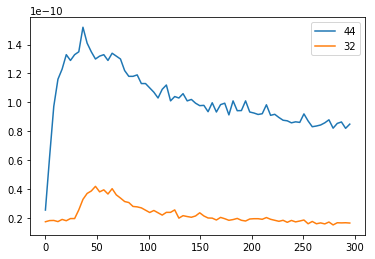

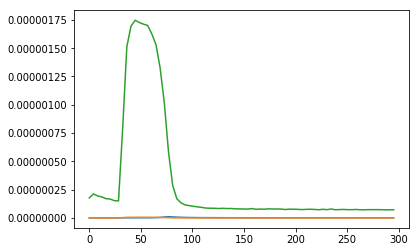

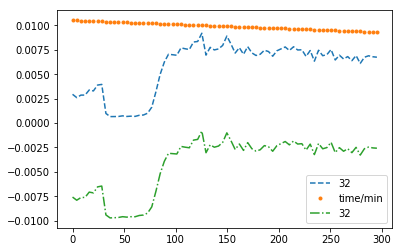

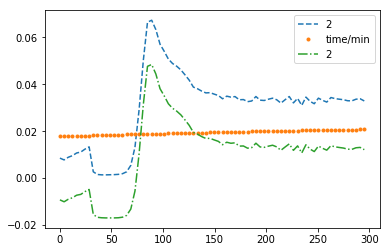

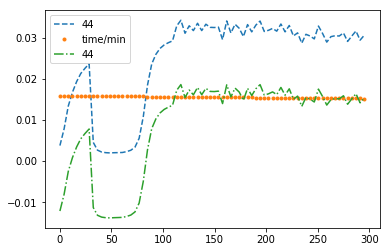

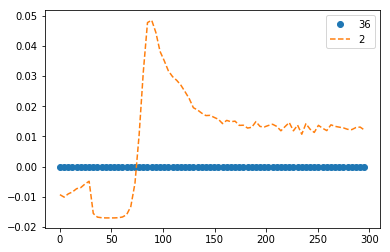

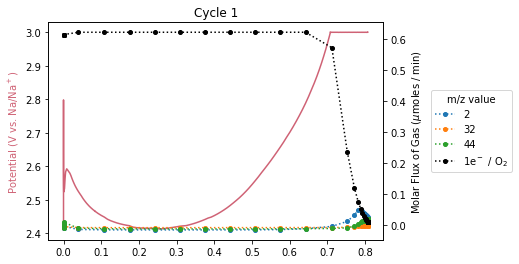

In [126]:
fold1='/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/'
isotope1= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/')
d1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190213_Na_CA_C13_18O2cycling_cell1/190213_Na_CA_C13_18O2cycling_cell1_chrg_cycle1_2019-02-13_12.42_12_ch1.txt')

plot_dems2(isotope1, d1, r=1, n=1)

/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log
/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in log


2.987647649006623
33.66450788815638
umoles O2: 33.66450788815638
e per mol: 1.0738749409187367
2.985705142857142
33.861506474642624
umoles O2: 33.861506474642624
e per mol: 1.0939439744779187


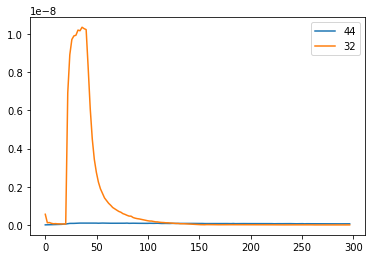

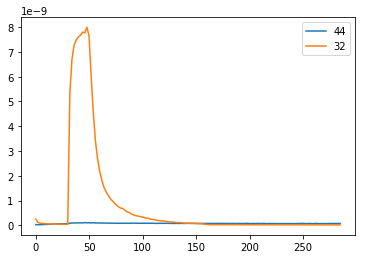

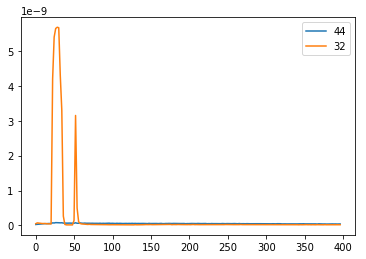

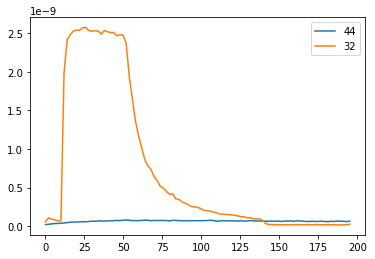

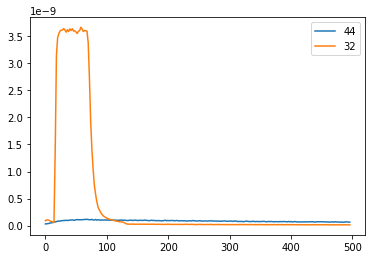

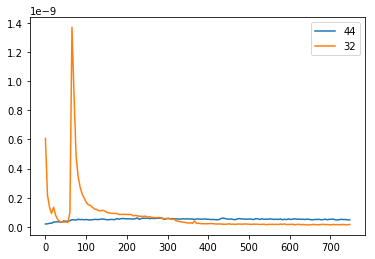

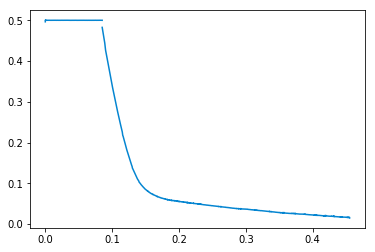

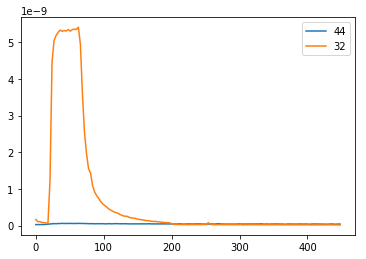

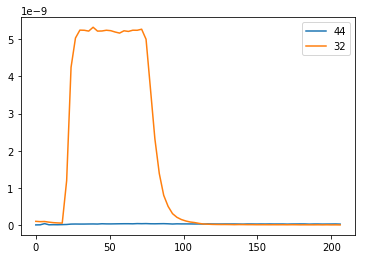

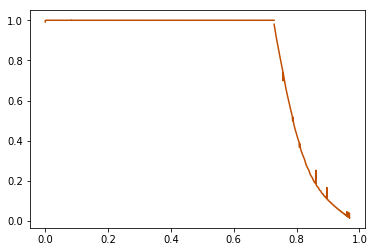

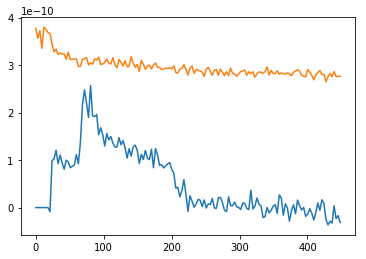

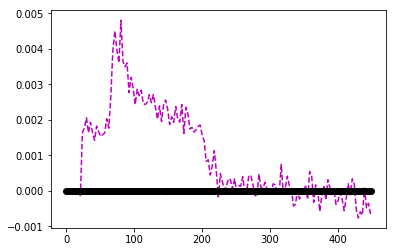

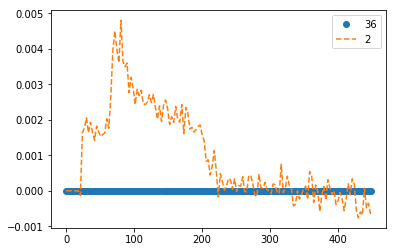

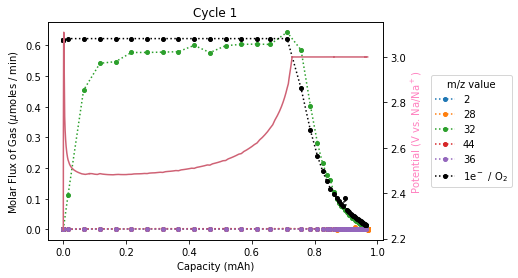

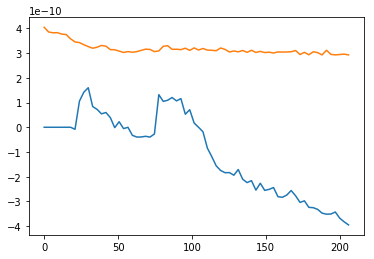

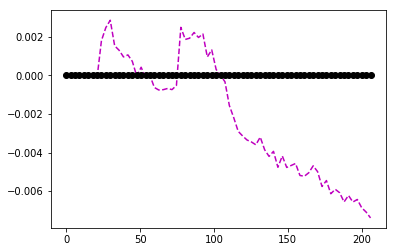

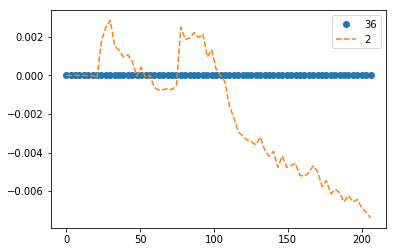

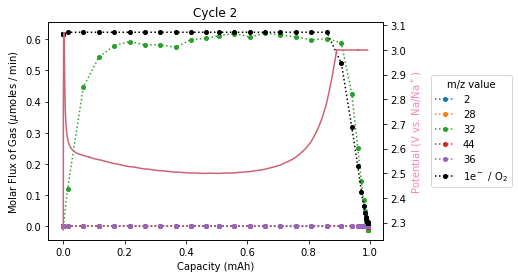

In [18]:

na_dems = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180709_sodium_chronoamp_3V_DEMS_2/')
na_dems2 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180709_sodium_chronoamp_3V_DEMS_2/180709_sodium_chronoamp_3V_DEMS_2_chrg_rnd2_2018-07-09_18.48_40.txt')
na_disch= read_data('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180709_sodium_chronoamp_3V_DEMS_2/180709_sodium_chronoamp_3V_DEMS_2_disch_05_CP_C01.mpt')

#plot_dems2(na_dems, na_dems2, n=1)
#plt.savefig('/Users/kedzie/Desktop/sodium dems charge vol corrected.png', transparent = True, dpi=600, bbox_inches='tight')

sodium_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180718_sodium_chronoamp_2cycles_dems/')
sodium_chrg1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180718_sodium_chronoamp_2cycles_dems/180718_Sodium_chronoamp_2cycles_dems_chrg_cycle1_2018-07-18_13.41_28.txt')

cycle2= [sodium_fold[5],sodium_fold[6],sodium_fold[7],sodium_fold[8]]
sodium_chrg2= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180718_sodium_chronoamp_2cycles_dems/180718_Sodium_chronoamp_2cycles_dems_chrg_cycle2_2018-07-18_20.37_41.txt')

#plot_dems2(sodium_fold, sodium_chrg1, time_min=100,  n=1)
#plt.savefig('/Users/kedzie/Desktop/sodium dems cycle1.png', transparent = True, dpi=600, bbox_inches='tight')

cycles_fold=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180731_sodiumchronoamp_2cycles_1mA_dems/')
cy1_dems =read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180731_sodiumchronoamp_2cycles_1mA_dems/180731_sodiumchronoamp_2cycles_1mA_dems_chrg_c1_2018-07-31_12.43_13.txt')

cy2fold= [cycles_fold[5], cycles_fold[6],cycles_fold[7], cycles_fold[8]]
cy2_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180731_sodiumchronoamp_2cycles_1mA_dems/180731_sodiumchronoamp_2cycles_1mA_dems_chrg_c2_2018-07-31_17.42_35.txt')

#plot_dems2(cycles_fold, cy1_dems, time_min=400, n=1)
#plt.savefig('/Users/kedzie/Desktop/sodium dems cycle1.png', transparent = True, dpi=600, bbox_inches='tight')


#plot_dems2(cy2fold, cy2_dems, time_min=400,  n=1)
#plt.savefig('/Users/kedzie/Desktop/sodium dems cycle2.png', transparent = True, dpi=600, bbox_inches='tight')

# plt.figure()
# plt.plot(disch1['Capacity/mA.h'], disch1['Ewe/V'], 'xkcd:cerulean', label='')
# plt.plot(1-cycles_fold[3]['Capacity/mA.h'], cycles_fold[3]['Ewe/V'], 'xkcd:cerulean', label='cycle 1')
# plt.plot(1-cycles_fold[2]['Capacity/mA.h'], cycles_fold[2]['Ewe/V'], 'xkcd:cerulean', label='')
# plt.plot(1-cycles_fold[1]['Capacity/mA.h'], cycles_fold[1]['Ewe/V'], 'xkcd:cerulean', label='')

# plt.plot(disch2['Capacity/mA.h'], disch2['Ewe/V'], 'xkcd:orange', label='cycle 2')
# plt.plot(1-cy2fold[1]['Capacity/mA.h'], cy2fold[1]['Ewe/V'], 'xkcd:orange', label='')
# plt.plot(1-cy2fold[2]['Capacity/mA.h'], cy2fold[2]['Ewe/V'], 'xkcd:orange', label='')
# plt.plot(1-cy2fold[3]['Capacity/mA.h'], cy2fold[3]['Ewe/V'], 'xkcd:orange', label='')

# plt.legend()

water=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180726_2000ppmwater_LiTFSI_chronoamp_dems/')
waterdems=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180726_2000ppmwater_LiTFSI_chronoamp_dems/180726_2000ppmwater_LiTFSI_chronoamp_dems_chrg_2018-07-26_15.25_53.txt')
dis= read_data('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180726_2000ppmwater_LiTFSI_chronoamp_dems/180726_2000ppmwater_LiTFSI_chronoamp_dems_disch_03_CP_C01.mpt')
allwater= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180809_2000ppmwater_LiTFSI_chronoamp_4V_dems/')
plt.figure()
plt.plot(allwater[1]['Capacity/mA.h'], allwater[1]['I/mA'], 'xkcd:cerulean', label ='')
plt.plot(allwater[1]['Capacity/mA.h'].iloc[-1]+ allwater[2]['Capacity/mA.h'], allwater[2]['I/mA'], 'xkcd:cerulean', label='Li')

na_ca_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/')
demscy1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180819_Na_chronoamp_cyclingstudy_dems_chrg_cycle1_2018-08-19_22.50_51.txt')

na_ca_c2 = na_ca_fold[5:10]
dc2  = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180819_Na_chronoamp_cyclingstudy_dems/180820_Na_chronoamp_cyclingstudy_dems_chrg_cycle2_2018-08-20_16.06_42.txt')
plt.figure()
plt.plot(na_ca_fold[1]['Capacity/mA.h'], na_ca_fold[1]['I/mA'], 'xkcd:burnt orange', label='')
plt.plot(na_ca_fold[1]['Capacity/mA.h'].iloc[-1]+na_ca_fold[2]['Capacity/mA.h'], na_ca_fold[2]['I/mA'], 'xkcd:burnt orange', label='')
plt.plot(na_ca_fold[1]['Capacity/mA.h'].iloc[-1]+na_ca_fold[2]['Capacity/mA.h'].iloc[-1]+na_ca_fold[3]['Capacity/mA.h'], na_ca_fold[3]['I/mA'], 'xkcd:burnt orange', label='Na')

plot_dems2(na_ca_fold, demscy1, 300, r=1, n=1)
#plt.savefig('/Users/kedzie/Desktop/dems na ca c1.png', transparent = True, dpi=600, bbox_inches='tight')
plot_dems2(na_ca_c2, dc2, 105, r=2, n=1)
#plt.savefig('/Users/kedzie/Desktop/dems na ca c2.png', transparent = True, dpi=600, bbox_inches='tight')


In [19]:


#-------------------------  script to plot dems  ------------------------------
#tdpa without nitrate
# demi=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_withoutNO3_DEMS_disch_chrg/180606_TDPA_withoutNO3_DEMS_chrg_2018-06-06_17.35_38.txt')
# chrg_ec=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_withoutNO3_DEMS_disch_chrg/')

#litfsi
# demi2=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_LiNO3_DEMS_chrg_only/180606_TDPA_LiNO3_DEMS_chrg_2018-06-06_17.35_38.txt')
# litfsi_ec=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180606_TDPA_LiNO3_DEMS_chrg_only/')

# tdpa_OG=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_25mMTDPA_disch_chrg/180510_25mMTDPA_chrg_dems_2018-05-10_15.13_09.txt')
# tdpa_ec=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_25mMTDPA_disch_chrg/')

dems_litfsi=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_1MLiTFSI_DME_disch_chrg_dems/180510_1MLiTFSI_DME_chrg_dems_2018-05-10_15.13_09.txt')
litfsi_ec2 = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2018/180510_1MLiTFSI_DME_disch_chrg_dems/')
#plot_dems(litfsi_ec2, dems_litfsi)
# plt.savefig('/Users/kedzie/Desktop/dems_litfsi_control.png', transparent = True, dpi=600, bbox_inches='tight')


# plot_dems(tdpa_ec, tdpa_OG)

# #plt.savefig('/Users/kedzie/Desktop/dems_tdpa_nitrate.png', transparent = True, dpi=600, bbox_inches='tight')


# plot_dems(chrg_ec, demi)

#plt.savefig('/Users/kedzie/Desktop/dems_tdpa_nonitratecontrol.png', transparent = True, dpi=600, bbox_inches='tight')

#plot_dems(litfsi_ec,demi2)
#plt.savefig('/Users/kedzie/Desktop/dems_lino3tdpa_chargeonly.png', transparent = True, dpi=600, bbox_inches='tight')
